In [187]:
import hashlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from termcolor import colored
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
from operator import itemgetter

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import os



In [188]:
IDX_FREQ_I = 0
IDX_TIME_J = 1
DEFAULT_FS = 44100
DEFAULT_WINDOW_SIZE = 4096
DEFAULT_OVERLAP_RATIO = 0.5
DEFAULT_FAN_VALUE = 15
DEFAULT_AMP_MIN = 10
PEAK_NEIGHBORHOOD_SIZE = 20
MIN_HASH_TIME_DELTA = 0
MAX_HASH_TIME_DELTA = 200
PEAK_SORT = True
FINGERPRINT_REDUCTION = 20
plots=True

In [189]:
file_name=input("Enter the audio file location ::")
if not file_name.lower().endswith('.wav'):
    print("Please specify a WAV file")
if os.path.exists(file_name)==False:
    print("Please enter the path of existing WAV file")

Enter the audio file location ::car.wav


In [190]:
sampling_frequency , data = wavfile.read(file_name)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


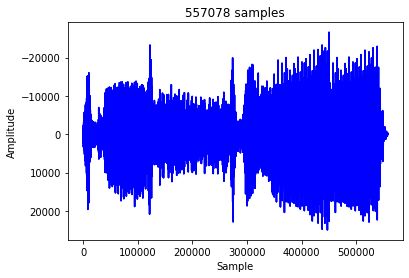

In [191]:
plt.plot(data,color='B')
plt.xlabel('Sample')
plt.title('%d samples' % len(data))
plt.ylabel('Amplitude')
plt.show
plt.gca().invert_yaxis()



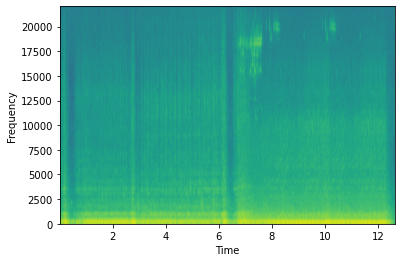

In [192]:
if plots :
    plt.specgram(data[:,0],Fs=44100)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show

In [193]:
arr2D = mlab.specgram(data[:,0],Fs=44100,window=mlab.window_hanning,NFFT=4096,noverlap=int(4096 * 0.5))[0]

## 

In [194]:

arr2D

array([[9.42388775e+00, 4.77731393e-01, 2.03110975e+01, ...,
        1.39795506e-02, 4.42334299e-02, 1.81711553e-03],
       [3.93094945e+01, 8.27598464e+01, 2.90847920e+01, ...,
        6.20178652e-01, 7.24513378e-01, 1.54852301e+00],
       [1.35905265e+02, 3.74368082e+02, 3.31927039e+01, ...,
        3.07782133e+00, 2.34619100e+01, 5.21890603e+00],
       ...,
       [9.08975570e-03, 5.46512079e-04, 2.46274280e-03, ...,
        3.21100825e-03, 6.54104804e-03, 3.84300035e-04],
       [6.43208078e-03, 4.96878147e-03, 3.26297766e-03, ...,
        9.11603503e-04, 4.49967426e-03, 7.45179560e-03],
       [8.79606974e-04, 3.08116497e-03, 1.65868758e-03, ...,
        2.94553632e-05, 1.26384725e-03, 3.77510125e-03]])

In [195]:
arr2D=np.asarray(arr2D)
arr2D



array([[9.42388775e+00, 4.77731393e-01, 2.03110975e+01, ...,
        1.39795506e-02, 4.42334299e-02, 1.81711553e-03],
       [3.93094945e+01, 8.27598464e+01, 2.90847920e+01, ...,
        6.20178652e-01, 7.24513378e-01, 1.54852301e+00],
       [1.35905265e+02, 3.74368082e+02, 3.31927039e+01, ...,
        3.07782133e+00, 2.34619100e+01, 5.21890603e+00],
       ...,
       [9.08975570e-03, 5.46512079e-04, 2.46274280e-03, ...,
        3.21100825e-03, 6.54104804e-03, 3.84300035e-04],
       [6.43208078e-03, 4.96878147e-03, 3.26297766e-03, ...,
        9.11603503e-04, 4.49967426e-03, 7.45179560e-03],
       [8.79606974e-04, 3.08116497e-03, 1.65868758e-03, ...,
        2.94553632e-05, 1.26384725e-03, 3.77510125e-03]])

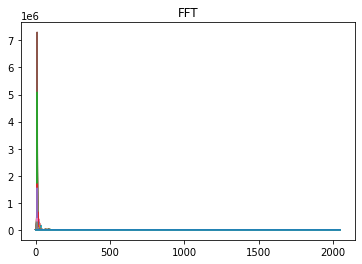

In [196]:
if plots :
    plt.plot(arr2D)
    plt.title('FFT')
    plt.show()


In [197]:
arr2D = 10 * np.log10(arr2D) 
arr2D[arr2D == -np.inf]
arr2D

array([[  9.74230104,  -3.20816219,  13.07733392, ..., -18.54506789,
        -13.54249383, -27.40617461],
       [ 15.94497459,  19.17819676,  14.63665962, ...,  -2.07483187,
         -1.39953591,   1.89917664],
       [ 21.33236282,  25.73298815,  15.21042632, ...,   4.88243406,
         13.70363364,   7.17579477],
       ...,
       [-20.41447789, -32.62400235, -26.08580942, ..., -24.93358579,
        -21.84352661, -34.15329575],
       [-21.9164851 , -23.03750104, -24.86385899, ..., -30.40194015,
        -23.46818924, -21.27739066],
       [-30.55711336, -25.11285049, -27.80235407, ..., -45.30835618,
        -28.98305413, -24.23071396]])

In [200]:
def get_2D_peaks(arr2D, plot=False, amp_min=DEFAULT_AMP_MIN):
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, PEAK_NEIGHBORHOOD_SIZE)

    # find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max ^ eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    # scatter of the peaks
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(time_idx, frequency_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()

    return zip(frequency_idx, time_idx)

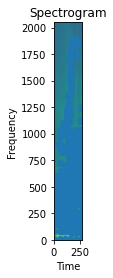

In [201]:
local_maxima = get_2D_peaks(arr2D, plot=plots, amp_min=DEFAULT_AMP_MIN)
local_maxima

In [202]:
x=list(local_maxima)
y=len(x)

In [203]:
msg = "  local_maxima: "+str(y)+" of frequency & time pairs"
print ( msg ) 


  local_maxima: 232 of frequency & time pairs


In [204]:
print("Freq and Time pairs are:")
print(x)

Freq and Time pairs are:
[(8, 4), (9, 60), (9, 150), (9, 215), (9, 262), (10, 104), (64, 215), (65, 176), (65, 257), (85, 77), (87, 4), (87, 58), (87, 96), (87, 132), (112, 180), (113, 71), (113, 225), (135, 188), (140, 132), (144, 114), (147, 167), (149, 30), (149, 69), (149, 216), (150, 96), (150, 145), (151, 3), (155, 261), (167, 180), (173, 114), (178, 4), (179, 63), (180, 133), (186, 77), (194, 180), (194, 218), (194, 263), (200, 114), (206, 71), (218, 33), (221, 3), (222, 123), (224, 58), (227, 146), (227, 197), (240, 222), (241, 186), (257, 170), (258, 216), (258, 262), (270, 51), (270, 102), (282, 3), (289, 147), (292, 102), (293, 58), (293, 183), (294, 36), (316, 83), (323, 119), (324, 179), (330, 3), (330, 31), (330, 59), (331, 214), (331, 259), (336, 144), (356, 248), (357, 203), (360, 59), (364, 183), (369, 90), (372, 215), (378, 3), (379, 113), (385, 254), (389, 236), (390, 190), (395, 133), (396, 105), (403, 175), (405, 204), (405, 250), (406, 146), (409, 57), (410, 77), 

In [205]:
import operator
x.sort(key=operator.itemgetter(1))
print(x)

[(151, 3), (221, 3), (282, 3), (330, 3), (378, 3), (411, 3), (455, 3), (531, 3), (900, 3), (8, 4), (87, 4), (178, 4), (596, 18), (504, 19), (470, 28), (149, 30), (330, 31), (218, 33), (294, 36), (270, 51), (409, 57), (87, 58), (224, 58), (293, 58), (506, 58), (574, 58), (727, 58), (854, 58), (902, 58), (967, 58), (989, 58), (1022, 58), (330, 59), (360, 59), (462, 59), (9, 60), (179, 63), (606, 68), (149, 69), (113, 71), (206, 71), (651, 74), (85, 77), (186, 77), (410, 77), (986, 77), (1043, 78), (827, 82), (316, 83), (573, 85), (1102, 89), (369, 90), (466, 90), (508, 90), (87, 96), (150, 96), (434, 97), (490, 97), (564, 101), (1059, 101), (270, 102), (292, 102), (10, 104), (396, 105), (518, 105), (642, 109), (836, 109), (454, 112), (861, 112), (379, 113), (144, 114), (173, 114), (200, 114), (323, 119), (709, 120), (222, 123), (1058, 124), (1081, 124), (1109, 124), (1158, 124), (1191, 124), (672, 125), (848, 125), (1220, 127), (526, 131), (871, 131), (1143, 131), (87, 132), (140, 132), 

In [207]:
def generate_hashes(peaks, fan_value=DEFAULT_FAN_VALUE):
 
    # bruteforce all peaks
    for i in range(len(peaks)):
        for j in range(1, fan_value):
            if (i + j) < len(peaks):

                # take current & next peak frequency value
                freq1 = peaks[i][IDX_FREQ_I]
                freq2 = peaks[i + j][IDX_FREQ_I]

                # take current & next -peak time offset
                t1 = peaks[i][IDX_TIME_J]
                t2 = peaks[i + j][IDX_TIME_J]

                # get diff of time offsets
                t_delta = t2 - t1

                # check if delta is between min & max
                if t_delta >= MIN_HASH_TIME_DELTA and t_delta <= MAX_HASH_TIME_DELTA:
                    data="%s%s" % (str(freq1),str(t1))
                    h=hashlib.md5(str(data).encode('utf-8'))
                    yield (h.hexdigest()[0:FINGERPRINT_REDUCTION],t1)

In [208]:
h=generate_hashes(x, fan_value=DEFAULT_FAN_VALUE)
print(h)

<generator object generate_hashes at 0x7f0656b8d048>


In [209]:
hash_list=list(set(h))

In [210]:
len_hash=len(hash_list)
print("lenght is :"+str(len_hash))
print(list(hash_list))

lenght is :231
[('b9c565b031d5aba707eb', 146), ('8be6af45b7f0c68da160', 260), ('de16bd7c7dc111bbb259', 197), ('8306ef53581c28ec02d9', 248), ('670586f4afd09b02990f', 240), ('d19c05d76ddac6036569', 144), ('7592bdb294779ec59b24', 160), ('46edde33f9278e78f239', 214), ('818a96c8227979a49df9', 195), ('e2e5096d574976e8f115', 96), ('550c9dcbff4f3c8903f2', 175), ('760aa794f4a28caa7b54', 160), ('ba4e886e31aeac9d4310', 251), ('8b5e7836dd068601d1d8', 19), ('f7f461112d64153a6e5f', 204), ('7223a260d6245448d5f3', 145), ('2a1a38e47ee2d3063134', 228), ('c7357dcf562108aba6f0', 262), ('eb7dceb50b0e3dec98d3', 114), ('51970b1959baa2e74926', 215), ('c118e9e92cb7a9805114', 58), ('ca63df6aff59b9838a3b', 246), ('6a65ded40a06bff1e122', 132), ('0801b20e08c3242125d5', 262), ('4a90df0803c61aab5c31', 63), ('4a47f5b25a44042b00c6', 133), ('51bdcefc2ab286f87800', 85), ('99d6995d6c38a1f26cb7', 74), ('44b5d7c6df3546537041', 203), ('ea3006a16306c51eed62', 157), ('9a823590ec6360406da5', 167), ('75ab61e86aa3babfe168', 216)